---
output:
  html_document:
    toc: true
    toc_float: true
---
I suppose this doesn't work in notebooks

# Introduction

"Five-subunit early endosomal Rab5 and RNA/ribosome intermediary" (FERRY) is a protein complex capable of acting as a bridge between mRNA and Rab5. Rab5 is a small GTPase protein that plays a key role in regulating membrane trafficking and late-endocytic processes within cells, which makes the FERRY complex a prime candidate for early endosome-mediated mRNA transport. 
In fact, late endocytic organelles primarily undergo minus-end microtubule-directed motility, whcih would allow to employ them for the transport of mRNA to areas distant from the cell body, such as dendrites and axons in neurons.

Selective inactivation of the FERRY subunits may shed more light on the functional role of each of each of these components, and their impact on cell homeostasis especially in dendritic components. 

# FERRY components
In the experiment, selective KO of fy-1, fy-2, fy-4 and fy-5 was perfored. Recent CRYO-EM observations suggest that fy-2 plays a key role as a central scaffolding unit, and possesses a close interaction with fy-4.
# Data analysis

## Count table structure

- The samples are a triplicate of each of the four FERRY component KOs, plus the wt controls:

In [1]:
count_table <- read.table("/sharedFolder/dataset/GSE230114_count_matrix.tsv", sep="\t", header = TRUE, row.names=1)
dim(count_table)
colnames(count_table)

[1] 58178    15

[1] "fy.1_KO1" "fy.1_KO2" "fy.1_KO3" "fy.2_KO1" "fy.2_KO2" "fy.2_KO3"
 [7] "fy.4_KO1" "fy.4_KO2" "fy.4_KO3" "fy.5_KO1" "fy.5_KO2" "fy.5_KO3"
[13] "wt_1"     "wt_2"     "wt_3"

- The count table contains additional mapping info at the top four rows which needed to be removed to perform analysis.

Before proceeding it is noticeable how the fy.1_KO1 element has more unmapped reads than average indicating perhaps a bad preparation of the sample, which may make it an outlier in the statistial analysis. 

In [2]:
head(count_table)

,fy.1_KO1,fy.1_KO2,fy.1_KO3,fy.2_KO1,fy.2_KO2,fy.2_KO3,fy.4_KO1,fy.4_KO2,fy.4_KO3,fy.5_KO1,fy.5_KO2,fy.5_KO3,wt_1,wt_2,wt_3
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
N_unmapped,21501758,14869105,13247861,14494385,13040253,11952915,15222983,12448629,13599320,12440218,13883415,12828977,17359917,19654977,17523561
N_multimapping,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
N_noFeature,21469294,22380469,24184545,26413005,26851984,27750888,21915436,21485648,21331186,26289304,23351477,21004878,25005705,23406843,21369740
N_ambiguous,4214196,2930260,2753066,2801228,2973540,2612770,3552453,2837547,3007814,3636922,3124712,3242532,3475218,3451936,3694677
ENSG00000223972,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1
ENSG00000227232,289,274,268,307,287,324,261,234,242,278,278,262,234,258,290


In [3]:
count_table <- count_table[-c(1:4),] #first four rows are excluded
count_table[1:3,1:6]

,fy.1_KO1,fy.1_KO2,fy.1_KO3,fy.2_KO1,fy.2_KO2,fy.2_KO3
,<int>,<int>,<int>,<int>,<int>,<int>
ENSG00000223972,0,1,1,0,0,0
ENSG00000227232,289,274,268,307,287,324
ENSG00000278267,0,0,0,0,0,1


## Annotation
The gene symbols were annotated from the hg38 assembly, as the alignment for this dataset has been produced recently.

The annotated count table of the protein coding genes was obtained with the following string of commands, which was executed on Rstudio due to the limited processing capabilities of my docker environment and, in general, of my laptop.

------
### Preparing the annotation
```r
gtf <- read.table("Homo_sapiens.GRCh38.109.gtf", sep="\t", header=T)
gtf1 <- gtf[which(gtf$gene == "gene"),]
# the 9th column of this table contains the required set "genes"
gtf1_annotation <- gtf1[,9]
# removing the genes that are not named and that do not code for proteins
gtf1_annotation <- gtf1_annotation[grep("gene_name ", gtf1_annotation )]
gtf1_annotation <- gtf1_annotation[grep("protein_coding", gtf1_annotation )]
gtf1_annotation_lst <- strsplit(gtf1_annotation, "; ")
gtf1_annotation_df <- as.data.frame(gtf1_annotation_lst)
# the table is translated to visualise the annotations as columns 
gtf1_annotation_df <- as.data.frame(t(gtf1_annotation_df))
# extrapolating the ids and the symbols, and naming the columns
gtf1_annotation_df <- gtf1_annotation_df[,c(1,3)] 
names(gtf1_annotation_df) <- c("ensemblid","symbol")
# removing the descriptors from the values
gtf1_annotation_df$ensemblid <- gsub("gene_id ", "", gtf1_annotation_df$ensemblid)
gtf1_annotation_df$symbol <- gsub("gene_name ", "", gtf1_annotation_df$symbol)
# naming the rows "ensemblid:symbol"
rownames(gtf1_annotation_df) <- paste(gtf1_annotation_df$ensemblid, gtf1_annotation_df$symbol, sep=":")
# removing duplicates from symbols and ensemblids (no duplicates were present in the second instance)
gtf1_annotation_df <- gtf1_annotation_df[!duplicated(gtf1_annotation_df$symbol),]
gtf1_annotation_df <- gtf1_annotation_df[!duplicated(gtf1_annotation_df$ensemblid),]

```
-----
### Annotating the count table
```r
count_table <- read.table("count_table_newcol.tsv", sep="\t", header = TRUE, row.names=1)
# filtering out from the annotation the genes that are not present in the count table
gtf1_annotation_filtered <- gtf1_annotation_df[which(gtf1_annotation_df$ensemblid %in% rownames(count_table)),]
# filtering out the npc genes from the count table (they were excluded from the annotation)
count_table <- count_table[which(rownames(count_table) %in% gtf1_annotation_df$ensemblid),]
# ordering both the count and annotation table by their ensembl ids
gtf1_annotation_filtered <- gtf1_annotation_filtered[order(gtf1_annotation_filtered$ensemblid),]
count_table <- count_table[order(rownames(count_table)),]
# checking if the ids match after being ordered
identical(rownames(count_table), gtf1_annotation_filtered$ensemblid)
# substituting the ids in the count table with the gene symbols
rownames(count_table) <- gtf1_annotation_filtered$symbol
write.table(count_table, "annotated_count_table.tsv", sep="\t", col.names = NA)
```
-------
The annotated count table was then copied into the dataset folder

## Log2 CPM

In [4]:
suppressMessages(library(edgeR))
library(limma)

cpm_mat <- cpm(count_table)
log2_cpm_mat = log2(cpm_mat + 1)

In [5]:
log2_cpm_mat[1:3,1:6]

,fy.1_KO1,fy.1_KO2,fy.1_KO3,fy.2_KO1,fy.2_KO2,fy.2_KO3
ENSG00000223972,0.000000,0.0298045,0.03121304,0.000000,0.000000,0.0000000
ENSG00000227232,2.417888,2.7483357,2.77850699,2.908024,2.709171,3.0621210
ENSG00000278267,0.000000,0.0000000,0.00000000,0.000000,0.000000,0.0323708


## PCA

The column names need to be modified to allow for an easier labelling of the samples with PCA.
This renaming will be done on both the count and log2cpm conversion of the data.

In [6]:
colnames(count_table) <- c("KO1_fy1","KO2_fy1","KO3_fy1","KO1_fy2","KO2_fy2","KO3_fy2","KO1_fy4","KO2_fy4","KO3_fy4","KO1_fy5","KO2_fy5","KO3_fy5","HeLa1_wt","HeLa2_wt","HeLa3_wt")
colnames(log2_cpm_mat) <- colnames(count_table)

 The matrixes were saved as .tsv to allow their use by the pca function.

In [7]:
write.table(log2_cpm_mat, "/sharedFolder/dataset/log2_cpm_newcol.tsv", sep="\t", col.names = NA) 
write.table(count_table, "/sharedFolder/dataset/count_table_newcol.tsv", sep="\t", col.names = NA) 

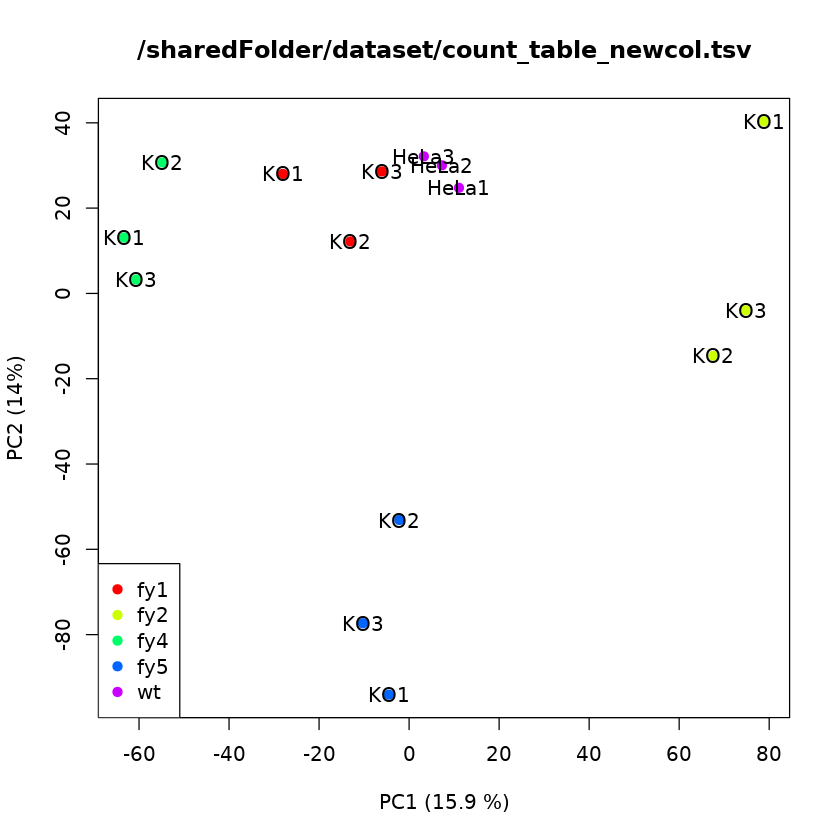

In [8]:
source("/sharedFolder/docker4seq-master/R/pca.R")
pca(
    experiment.table = "/sharedFolder/dataset/count_table_newcol.tsv",
    type = "counts",
    covariatesInNames = TRUE,
    samplesName = TRUE,
    principal.components = c(1, 2),
    legend.position = "bottomleft",
    pdf = FALSE
    )

- There seems to be a good separation already, but it could be made clearer with a logarythmic transformation.

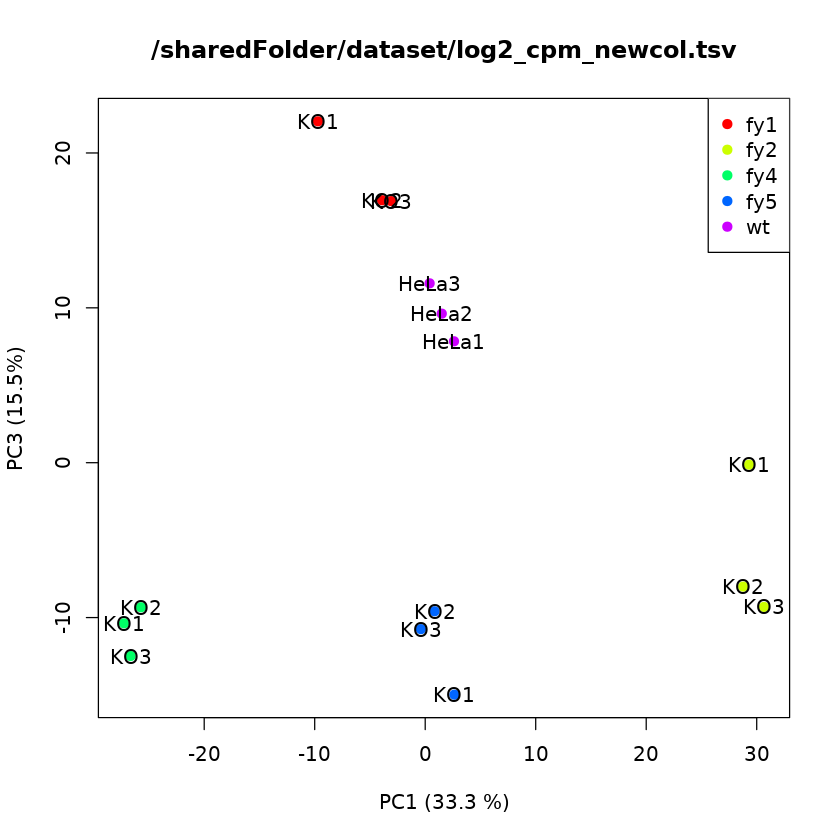

In [9]:
pca(
    experiment.table = "/sharedFolder/dataset/log2_cpm_newcol.tsv",
    type = "TPM",
    covariatesInNames = TRUE,
    samplesName = TRUE,
    principal.components = c(1,3),
    legend.position = "topright",
    pdf = FALSE
    )

- Let's analyse how much of the variance is explained by each principal component.

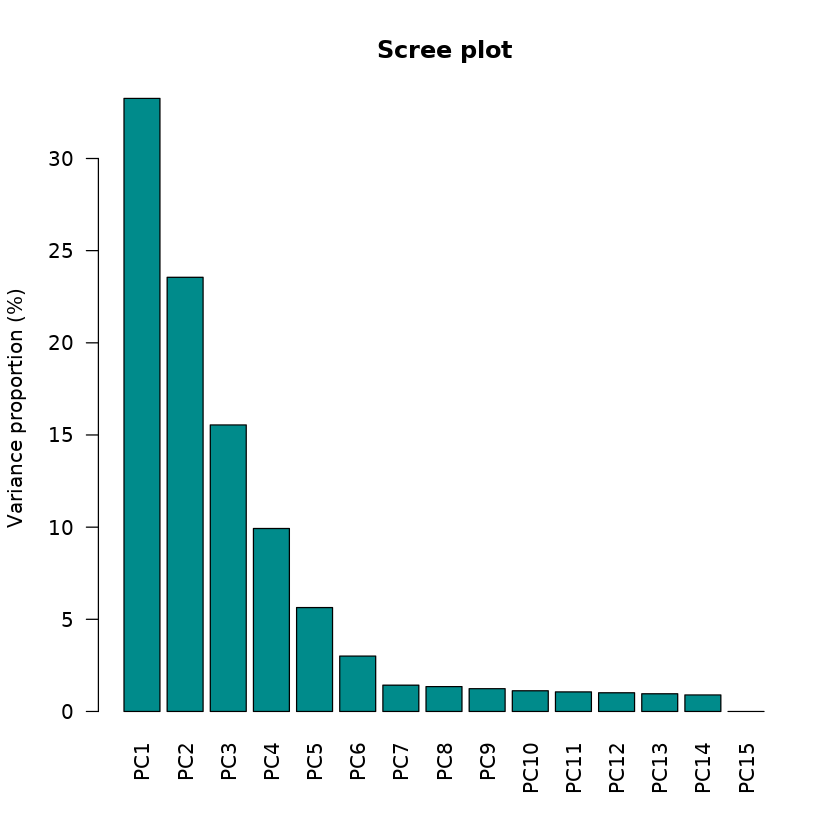

In [10]:
pca <- prcomp(t(log2_cpm_mat))
x <- factor(colnames(summary(pca)$importance), levels=colnames(summary(pca)$importance))
barplot(summary(pca)$importance[2,]*100,names.arg=x, las=2, ylab="Variance proportion (%)", main="Scree plot", col="darkcyan")

Despite the steep reduction of explained variance, the first principal component can only account for 35% of the whole picture. This suggests a more complex interplay of factors.

# tSNE & UMAP

In [11]:
library(Rtsne)
library(umap)
library(ggplot2)

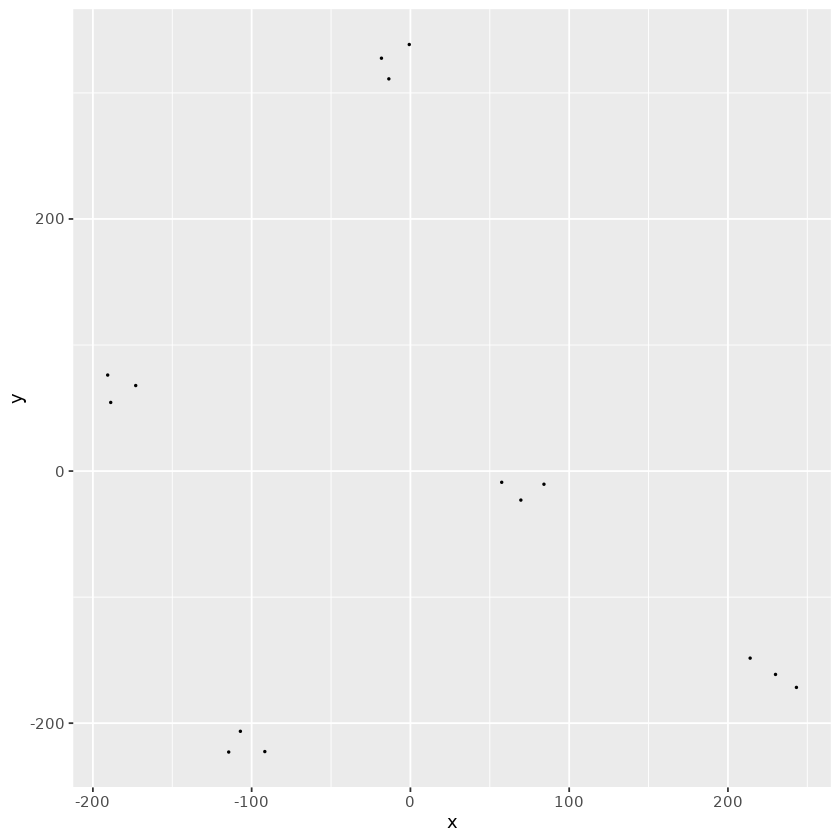

In [12]:
set.seed(111)
tsne.out <- Rtsne(t(log2_cpm_mat), pca = FALSE, perplexity = 2) # Run TSNE
f <- data.frame(x = as.numeric(tsne.out$Y[,1]), y = as.numeric(tsne.out$Y[,2]))
sp <- ggplot(f, aes(x=x, y=y)) + geom_point(pch = 19, cex = 0.3)
sp

- For umap I am going to work with the annotated count table as it only contains the counts for the protein coding genes. 
The results can be later used for k-mean clustering and gene onthology, as GO works with protein coding genes only.

In [13]:
ann_count_table <- read.table("/sharedFolder/dataset/annotated_count_table.tsv", sep="\t", header = TRUE, row.names=1)
cpm_mat <- cpm(ann_count_table)
ann_log2_cpm_mat = log2(cpm_mat + 1)
colnames(ann_log2_cpm_mat) <- colnames(log2_cpm_mat)
colnames(ann_count_table) <- colnames(log2_cpm_mat)

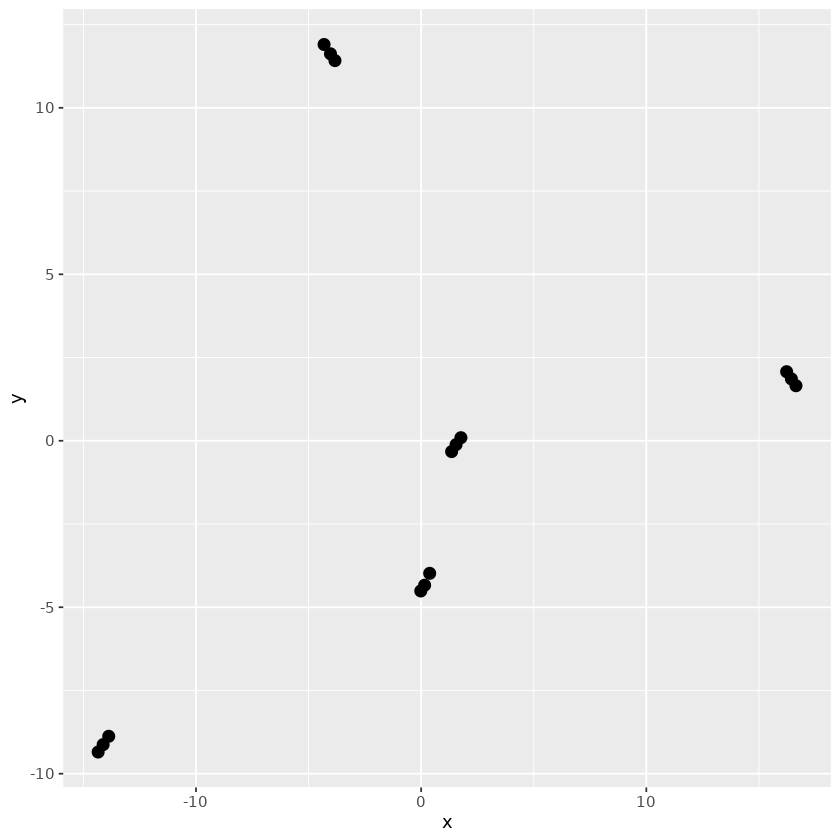

In [14]:
set.seed(111)
umap.out <- umap(t(ann_log2_cpm_mat), n_epochs = 1000, min_dist = 0.01, n_neighbors = 4) 
f=data.frame(x=as.numeric(umap.out$layout[,1]), y=as.numeric(umap.out$layout[,2]))
sp <- ggplot(f, aes(x=x, y=y)) + geom_point(pch = 19, cex = 3)
sp

The clustering seems to stay consistent after the removal of the non coding genes from the expression data.

## K-mean clustering

In [15]:
library(ClusterR)

set.seed(111)
km <- KMeans_arma(f, clusters = 5, n_iter = 30, seed_mode = "random_subset", verbose = T)
pr <- predict_KMeans(f, km)

kmeans(): generating initial means
kmeans(): n_threads: 4
kmeans(): iteration:    1   delta: 20.7874
kmeans(): iteration:    2   delta: 2.30537
kmeans(): iteration:    3   delta: 0


In [16]:
pr <- as.factor(pr)
pr

[1] 5 5 5 3 3 3 2 2 2 1 1 1 4 4 4
Levels: 1 2 3 4 5

In [17]:
class(km) <- "matrix"

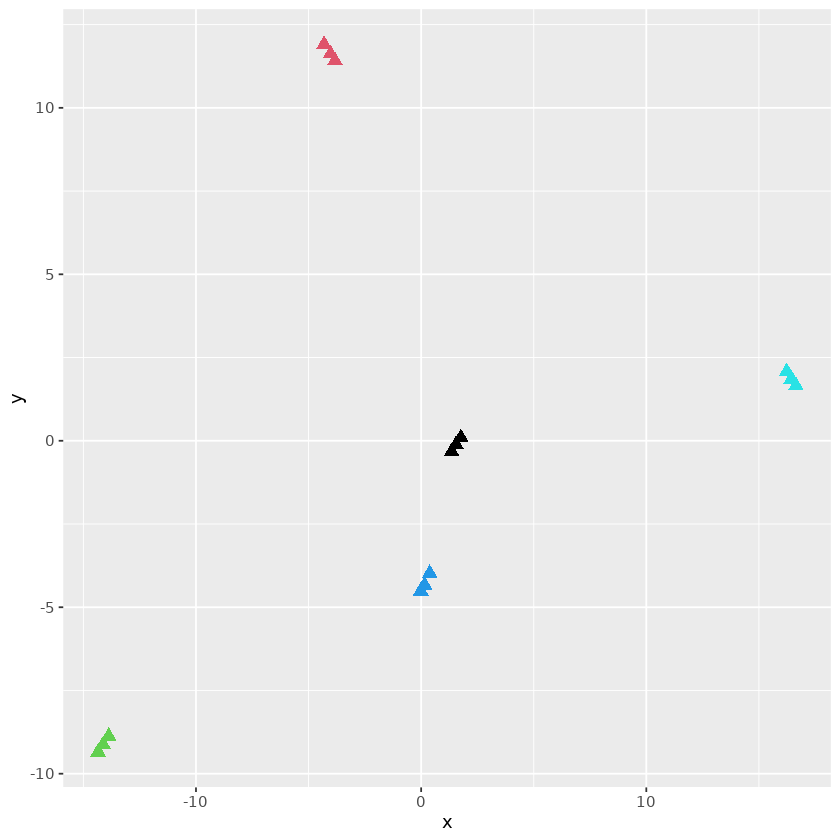

In [18]:
sp <- ggplot(f, aes(x=x,y=y)) + geom_point(pch=17, cex=3, color=pr)
sp

- Assigning the samples to each k-mean rank they belong to 

In [19]:
rownames(f) <- names(ann_count_table)
rownames(f) <- paste(rownames(f), as.character(pr), sep=":")
names(ann_count_table) <- rownames(f)
ann_count_table <- as.data.frame(ann_count_table)

- Summing the counts between all the samples that were ranked together

In [20]:
# cls4 <- ann_count_table[,11]
# names(cls4) <- rownames(ann_count_table)
cls1 <- apply(ann_count_table[,grep(":1$", colnames(ann_count_table))], 1, sum)
cls2 <- apply(ann_count_table[,grep(":2$", colnames(ann_count_table))], 1, sum)
cls3 <- apply(ann_count_table[,grep(":3$", colnames(ann_count_table))], 1, sum)
cls4 <- apply(ann_count_table[,grep(":4$", colnames(ann_count_table))], 1, sum)
cls5 <- apply(ann_count_table[,grep(":5$", colnames(ann_count_table))], 1, sum)
cls <- data.frame(cls1, cls2, cls3, cls4, cls5)

-  There may be instances in which one of the levels clusteres as one single column. In those cases the apply() function is unable to work and it is necessary to use the commented commands instead.

- Proceeding with the log2cpm conversion and the normalisation of the clustered counts

In [21]:
col_sum <- apply(cls, 2, sum)
cls_rank <- t(cls)/col_sum
cls_rank <- as.data.frame(t(cls_rank) * 1000000)
cls_rank_log <- log2(cls_rank + 1)

cls_rank_log_mean <- apply(cls_rank_log, 1, mean)
cls_rank_log_normalised <- cls_rank_log - cls_rank_log_mean

log2_cpm_mat_mean <- apply(ann_log2_cpm_mat, 1, mean)
log2_cpm_mat_normalised <- ann_log2_cpm_mat - log2_cpm_mat_mean

In [22]:
cls_mat_n <- data.frame(log2_cpm_mat_normalised, cls_rank_log_normalised)

png 
  2

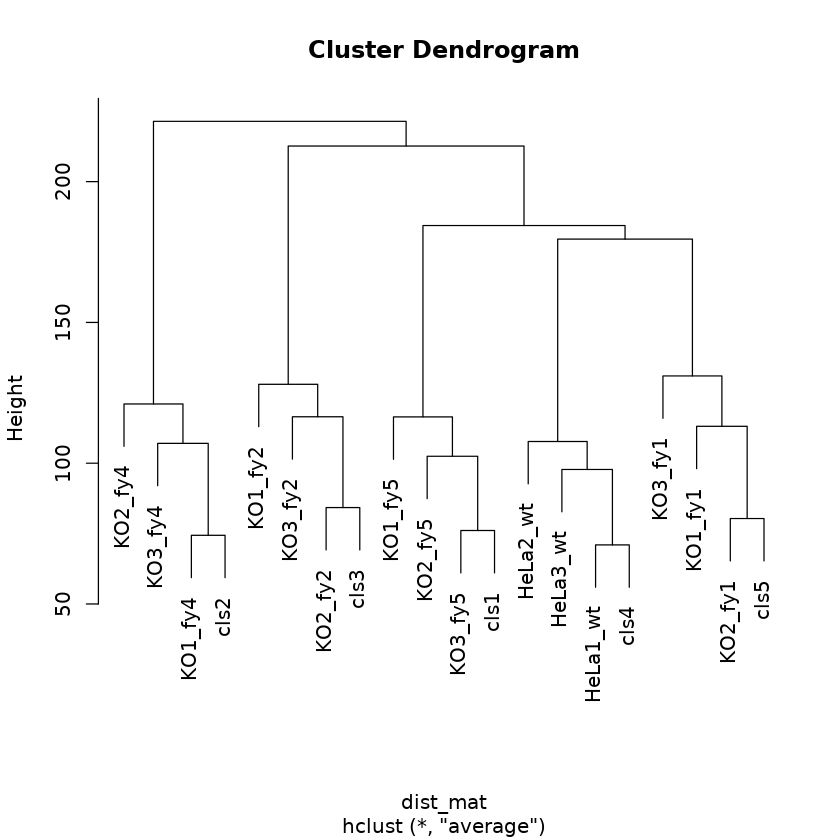

In [23]:
set.seed(111)
cls_mat_n <- as.data.frame(scale(t(cls_mat_n)))
dist_mat <- dist(cls_mat_n, method = "euclidean")
hclust_avg <- hclust(dist_mat, method = "average")
pdf("/sharedFolder/results/hclust_res.pdf")
plot(hclust_avg)
dev.off()
plot(hclust_avg)

We can see from this result that every KO line posesses a characteristical transcription profile. WT and FY1 branch off last, suggesting a more similar transcriptional activity which was already noticeable in the pca results. 
This could suggest a varying degree of impact that each individual mutation has on the cell transcriptome, and the consequent deviation from the physiological state.

# DESeq2

To use this function we need to prepare the sample condition matrix.

In [24]:
colnames(ann_count_table) <- colnames(log2_cpm_mat)
coldata <- matrix(colnames(ann_count_table))
rownames(coldata) <- colnames(ann_count_table)
colnames(coldata) <- "condition"
coldata[c(1:3),] <- "FERRY1"
coldata[c(4:6),] <- "FERRY2"
coldata[c(7:9),] <- "FERRY4"
coldata[c(10:12),] <- "FERRY5"
coldata[c(13:15),] <- "CTRL"
coldata

,condition
KO1_fy1,FERRY1
KO2_fy1,FERRY1
KO3_fy1,FERRY1
KO1_fy2,FERRY2
KO2_fy2,FERRY2
KO3_fy2,FERRY2
KO1_fy4,FERRY4
KO2_fy4,FERRY4
KO3_fy4,FERRY4
KO1_fy5,FERRY5


In [25]:
suppressMessages(library("DESeq2"))

In [26]:
dds <- DESeqDataSetFromMatrix(countData = ann_count_table,
                              colData = coldata,
                              design = ~ condition)

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”


In [27]:
suppressMessages(dds <- DESeq(dds))

- Getting rid of unused variables to lighten the load on my laptop

In [28]:
save(count_table, file="/sharedFolder/save/count_table.rda")
save(dds, file="/sharedFolder/save/dds.rda")
rm(list = ls())
load("/sharedFolder/save/dds.rda")

- Using contrast with each of the FERRY component KOs against the control.

In [29]:
res_F1 <- results(dds, contrast=c("condition","FERRY1","CTRL"))
res_F2 <- results(dds, contrast=c("condition","FERRY2","CTRL"))
res_F4 <- results(dds, contrast=c("condition","FERRY4","CTRL"))
res_F5 <- results(dds, contrast=c("condition","FERRY5","CTRL"))

- Defining a **function** to filter the results

In [30]:
filter.res <- function(res, padj) 
{
    short_res <- res[is.na(res$padj) == 0,] #removing NA rows
    short_res <- short_res[short_res$padj <= padj,]
    short_res <- short_res[abs(short_res$log2FoldChange) >= 1,]
    print("Original number of genes:")
    print(nrow(res))
    print("Significant genes:")
    print(nrow(short_res))
    return(short_res)
}

In [31]:
short_res_F1 <- filter.res(res_F1, padj = 0.05)

[1] "Original number of genes:"
[1] 19306
[1] "Significant genes:"
[1] 313


In [32]:
short_res_F2 <- filter.res(res_F2, padj = 0.05)

[1] "Original number of genes:"
[1] 19306
[1] "Significant genes:"
[1] 533


In [33]:
short_res_F4 <- filter.res(res_F4, padj = 0.05)

[1] "Original number of genes:"
[1] 19306
[1] "Significant genes:"
[1] 650


In [34]:
short_res_F5 <- filter.res(res_F5, padj = 0.05)

[1] "Original number of genes:"
[1] 19306
[1] "Significant genes:"
[1] 529


In [35]:
write.table(short_res_F1, "/sharedFolder/save/listaF1.tsv", sep="\t", col.names = NA)
write.table(short_res_F2, "/sharedFolder/save/listaF2.tsv", sep="\t", col.names = NA) 
write.table(short_res_F4, "/sharedFolder/save/listaF4.tsv", sep="\t", col.names = NA) 
write.table(short_res_F5, "/sharedFolder/save/listaF5.tsv", sep="\t", col.names = NA) 

These differently expressed genes can be used to observe the similarities and differences in the transcriptome between the various KOs.

![Venn diagram]("/sharedFolder/results/venn_result.png")

# Discussion
Especially when looking at the clustering results, a great branching from the physiological state can be observed in the FY2 and FY4 KOs, further confirming the core role of the two components in the complex, and a lesser so of the FY1.
However, it is also interesting to notice how despite being involved in the same complex, all of the different KOs still show a significant amount of dissimilarity. This suggests that the KO of one of the components from this system does not lead to the same identical phenotype, such as one caused by a fully dysfunctional FERRY pathway. Therefore one could assume that either the various components have additional roles outside of this system, or that the ferry complex can still function to some extent without one of them, thus causing the observed array of gene expression profiles.